# Persistence Barcodes

Generates persistence barcodes using fuzzy UMAP algorithm from the toroidal grid cell paper.

- **Input:** Cleaned spike data automatically loaded from the TDA data manager
- **Output:** Persistence barcodes for homology groups H0-H2
- **Method:** Fuzzy simplicial sets -> distance matrix -> Ripser TDA

Author: @emilyekstrum & Gardner et al. (2022)
<br> 11/25/25

**Reference:** Gardner, R.J., Hermansen, E., Pachitariu, M. et al. Toroidal topology of population activity in grid cells. *Nature* 602, 123–128 (2022). https://doi.org/10.1038/s41586-021-04268-7

In [24]:
import os
import torch
import matplotlib
import random
import numpy as np
import pandas as pd
from matplotlib import animation, cm, transforms, pyplot as plt, gridspec as grd
import matplotlib.pyplot 
import pickle as pkl
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from ripser import Rips, ripser
from scipy import stats, signal, optimize
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from sklearn import preprocessing

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.style.use(['default', 'seaborn-v0_8-paper'])

In [ ]:
# import TDA utilities
import sys
from pathlib import Path

# add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# summary of available data
data_manager.print_summary()

TDA utilities loaded
TDA Data Manager Info
Workspace root: c:\Users\denmanlab\Desktop\Emily_rotation\TDA
Data directory: c:\Users\denmanlab\Desktop\Emily_rotation\TDA\data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 5 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 14 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGN_chromatic_gratings.pkl
  • LGN_color_exchange.pkl
  • LGN_drifting_gratings.pkl
  • LGN_luminance_flash.pkl
  • V1_chromatic_gratings.pkl
  and 3 more


## 1. Load in spike data and inspect files

In [ ]:
# load in spike data 
try:
    datas, recordings, dataset_info = data_manager.load_spike_data()
    print(f"Dataset: {dataset_info['filename']}")
    print(f"Sessions: {dataset_info['n_sessions']}")
    print(f"Session IDs: {recordings}")
    
    print("Data shapes:")
    for name, X in zip(recordings, datas):
        print(f"  {name}: {X.shape} ({'torch.Tensor' if isinstance(X, torch.Tensor) else 'numpy.ndarray'})")
    
    # to load a specific dataset, use:
    datas, recordings, dataset_info = data_manager.load_spike_data('V1_luminance_flash.pkl')

    region = dataset_info['filename'].split('_')[0]  # extract region from filename
    stim = dataset_info['filename'].split('_')[1] + "_" + dataset_info['filename'].replace('.pkl', '').split('_')[2]  # extract stimulus from filename
    
except Exception as e:
    print(f"Could not load data: {e}")
    print("\nTo fix issue:")
    print("1. Make sure you're in the TDA repository")
    print("2. Check that data/clean_spike_data.zip exists")
    print("3. Or manually add .pkl files to data/clean_spike_data/")

Multiple datasets available:
  1. LGN_chromatic_gratings.pkl
  2. LGN_color_exchange.pkl
  3. LGN_drifting_gratings.pkl
  4. LGN_luminance_flash.pkl
  5. V1_chromatic_gratings.pkl
  6. V1_color_exchange.pkl
  7. V1_drifting_gratings.pkl
  8. V1_luminance_flash.pkl

Using the first one.
Loading data: LGN_chromatic_gratings.pkl
Loaded 3 recording sessions
  Sessions: ['C155', 'C159', 'C161']
  Data shape: torch.Size([136000, 15])
Dataset: LGN_chromatic_gratings.pkl
Sessions: 3
Session IDs: ['C155', 'C159', 'C161']
Data shapes:
  C155: torch.Size([136000, 15]) (torch.Tensor)
  C159: torch.Size([136000, 177]) (torch.Tensor)
  C161: torch.Size([136000, 95]) (torch.Tensor)
Loading data: V1_luminance_flash.pkl
Loaded 7 recording sessions
  Sessions: ['d4', 'd5', 'd6', 'C155', 'C159', 'C160', 'C161']
  Data shape: torch.Size([5000, 283])


In [ ]:
# Fuzzy UMAP code from Gardner et al. (2022)
# RUN ME

import numba
from datetime import datetime 
import functools
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter, gaussian_filter1d, binary_dilation, binary_closing

# umap functions
@numba.njit(parallel=True, fastmath=True) 
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    """Compute fuzzy membership strengths for KNN graph."""
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals

@numba.njit(fastmath=True)
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    """Smooth KNN distances using UMAP methodology."""
    target = np.log2(k) * bandwidth
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):
            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
                else:
                    psum += 1.0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid

        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho

def sample_denoising(data, k=10, num_sample=500, omega=0.2, metric='euclidean'):    
    """Fuzzy UMAP sampling with greedy farthest point selection."""
    n = data.shape[0]
    F_D = np.zeros(n)
    
    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X, 1)
    
    # Greedy sampling
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all > -1
    inds_left[i] = False
    inds = np.zeros(num_sample, dtype=int)
    inds[0] = i
    
    for j in np.arange(1, num_sample):
        F -= omega * X[i, :]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[Fmax]
        i = inds_all[inds_left][Fmax]
        inds_left[i] = False   
        inds[j] = i
        
    d = np.zeros((num_sample, num_sample))
    for j, i in enumerate(inds):
        d[j, :] = X[i, inds]
        
    return inds, d, Fs

def plot_barcode(persistence, file_name = '', name = ''):
    diagrams_roll = {}
    filenames=glob.glob('Results/Roll/' + file_name + '_H2_roll_*')
    for i, fname in enumerate(filenames): 
        f = np.load(fname, allow_pickle = True)
        diagrams_roll[i] = list(f['diagrams'])
        f.close() 


    cs = np.repeat([[0,0.55,0.2]],3).reshape(3,3).T
    alpha=1
    inf_delta=0.1
    legend=True
    colormap=cs
    maxdim = len(persistence) - 1
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)


    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0])
        for i in np.arange(1,num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])




    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        min_birth = min(min_birth, np.min(persistence_dim))
        max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure()
    gs = grd.GridSpec(len(dims),1)


    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$", "$H_3$"] #, "$H_2$"
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        #axes.axis('off')
        axes.set_ylabel(f"H{dim}", fontsize=10)
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        dinds = np.argsort(dlife)[-30:]
        #dl1,dl2 = dlife[dinds[-2:]]
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)


        axes.plot([0,0], [0, indsall], c = 'k', linestyle = '-', lw = 1)
        axes.plot([0,indsall],[0,0], c = 'k', linestyle = '-', lw = 1)
        axes.tick_params(labelsize=5)
        axes.set_yticks([])
        axes.set_xlim([0, infinity])

## 2. Check datas tensor sizes for downsampling

In [ ]:
# check datas sizes and downsampling
for name, X in zip(recordings, datas):
    n = X.shape[0]
    print(f"  {name}: {n:,}")
    
    if n > 50000:
        print(f"    Large tensor - using aggressive downsampling")
    elif n > 20000:
        print(f"    Medium tensor - using moderate downsampling")
    else:
        print(f"    Small tensor - using small downsampling")

#  downsampling parameters
target_size = 350  # target after downsampling

downsampled_datas = []

for name, X in zip(recordings, datas):
    original_size = X.shape[0]
    
    if original_size > target_size:
        # calculate optimal downsampling factor
        factor = max(1, original_size // target_size)
        
        if isinstance(X, torch.Tensor):
            down = X[::factor, :]
        else:
            down = X[::factor].copy()
            
        downsampled_datas.append(down)
        reduction_pct = (1 - down.shape[0]/original_size) * 100
        print(f"  {name}: {original_size:,} to {down.shape[0]:,}")
    else:
        # No downsampling needed
        downsampled_datas.append(X)
        print(f"  {name}: {original_size:,} (no downsampling needed)")

  d4: 5,000
    Small tensor - using small downsampling
  d5: 5,000
    Small tensor - using small downsampling
  d6: 5,000
    Small tensor - using small downsampling
  C155: 5,000
    Small tensor - using small downsampling
  C159: 5,000
    Small tensor - using small downsampling
  C160: 5,000
    Small tensor - using small downsampling
  C161: 5,000
    Small tensor - using small downsampling
  d4: 5,000 to 358
  d5: 5,000 to 358
  d6: 5,000 to 358
  C155: 5,000 to 358
  C159: 5,000 to 358
  C160: 5,000 to 358
  C161: 5,000 to 358


### TDA mini lesson: Persistence barcodes

![persistence_barcode](persistence_barcode.png)

## Fuzzy UMAP Methodology Overview

The pipeline implements the fuzzy UMAP approach from Gardner et al.:

1. **Fuzzy KNN Graph Construction**: Build weighted graph using greedy farthest point sampling
   - Select most connected points, down-weight nearby points
   - Ensures coverage of less-dense data regions


2. **Distance & KNN Graph**: Compute pairwise distances and k-nearest neighbors

3. **UMAP-style Scale Estimation**: Find optimal sigma (scaling) and rho (nearest neighbor distance)
   - Ensures soft membership >= log2(k) for topology preservation


4. **Fuzzy Simplicial Set**: Convert KNN -> sparse adjacency matrix -> directed fuzzy graph
   - graph edges are "fuzzy" (weighted edges are probabilistic for connections rather than binary presence/abscence of edges) 


5. **Greedy Sampling**: Identify highly connected points using fuzzy similarities

6. **TDA**: Use fuzzy similarity matrix as input to Ripser for persistence computation

## 3. Run Fuzzy UMAP pipeline



Processing d4
PCA done - (n_samples=358, n_components=130)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


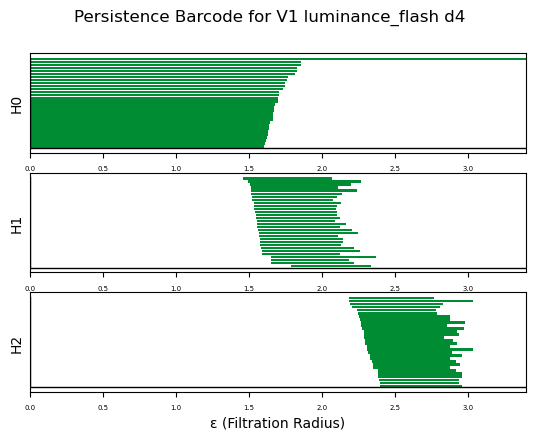

Betti numbers:
H0 Betti number (topological feature lifetime >= 2.2913): 1
H1 Betti number (topological feature lifetime >= 1.1757): 0
H2 Betti number (topological feature lifetime >= 1.3473): 0


Processing d5
PCA done - (n_samples=358, n_components=168)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


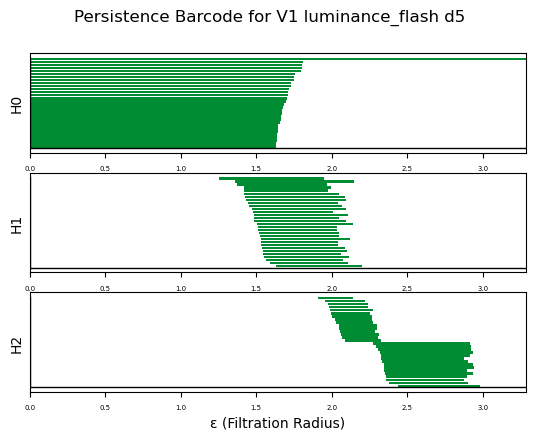

Betti numbers:
H0 Betti number (topological feature lifetime >= 2.1158): 1
H1 Betti number (topological feature lifetime >= 1.1144): 0
H2 Betti number (topological feature lifetime >= 1.2339): 0


Processing d6
PCA done - (n_samples=358, n_components=159)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


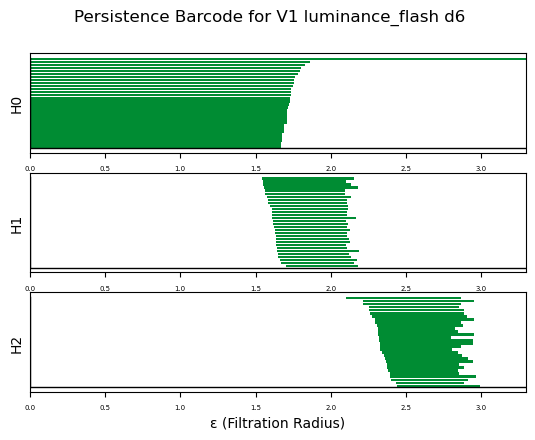

Betti numbers:
H0 Betti number (topological feature lifetime >= 2.1858): 1
H1 Betti number (topological feature lifetime >= 1.0660): 0
H2 Betti number (topological feature lifetime >= 1.2412): 0


Processing C155
PCA done - (n_samples=358, n_components=24)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


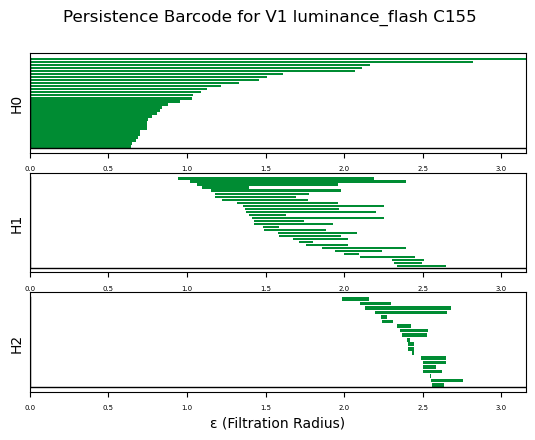

Betti numbers:
H0 Betti number (topological feature lifetime >= 2.2494): 2
H1 Betti number (topological feature lifetime >= 1.8967): 0
H2 Betti number (topological feature lifetime >= 1.5550): 0


Processing C159
PCA done - (n_samples=358, n_components=52)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


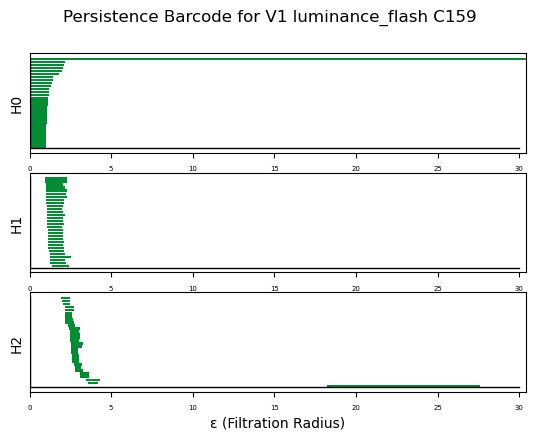

Betti numbers:
H0 Betti number (topological feature lifetime >= 1.7585): 6
H1 Betti number (topological feature lifetime >= 1.8977): 0
H2 Betti number (topological feature lifetime >= 2.2072): 1


Processing C160
PCA done - (n_samples=358, n_components=50)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


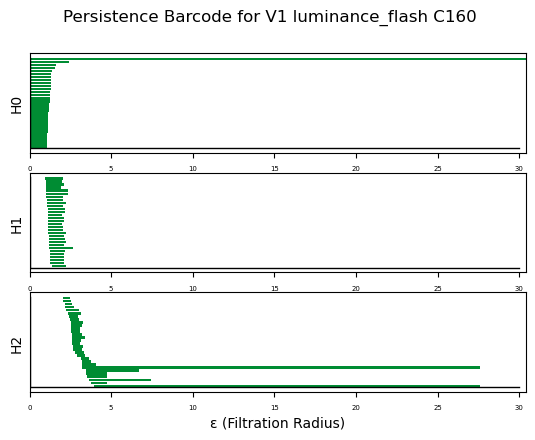

Betti numbers:
H0 Betti number (topological feature lifetime >= 1.7619): 2
H1 Betti number (topological feature lifetime >= 1.7520): 0
H2 Betti number (topological feature lifetime >= 4.6971): 2


Processing C161
PCA done - (n_samples=358, n_components=123)
Denoising done
KNN done
Membership strengths done
Negative log transform done
Distance matrix done
Ripser done


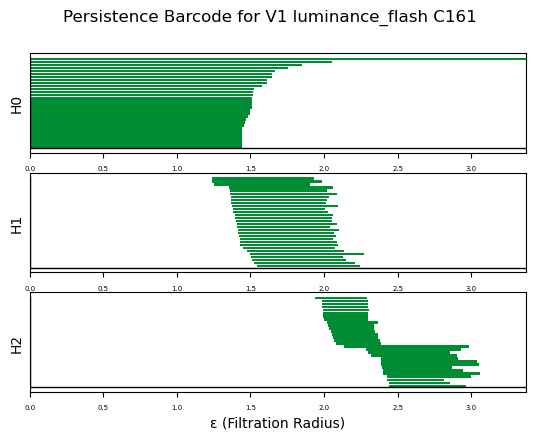

Betti numbers:
H0 Betti number (topological feature lifetime >= 1.9877): 2
H1 Betti number (topological feature lifetime >= 1.2877): 0
H2 Betti number (topological feature lifetime >= 1.3106): 0


In [ ]:
# edited from Gardner et al 2022
# for data preprocessing and ripser

#params
ph_classes = [0,1,2]
metric = 'cosine'
maxdim = 2
coeff = 2 # paper used 47 -> coefficient field
# coeff = 2 used here because assumed orientation doesn't matter for fixed head stimuli presentation as opposed to grid cell activity -> something to look into
n_points = target_size  # how many points to use in denoising - main downsampling parameter (set to same number as downsampled data for no downsampling)
nbs = n_points // 3  #number of neighbors for umap - param to look into
sigma = 1500

# loop through each recording
for name, X in zip(recordings, downsampled_datas):
    print(f"\n\nProcessing {name}")

    # normalize data
    X_scaled = StandardScaler().fit_transform(X)

    # ------------------------------------- PCA -------------------------------------------- 
    # optimize k for least dims that explain 90% variance but at least 32 
    pca_full = PCA(svd_solver='auto', random_state=42).fit(X_scaled)
    sum_var = np.cumsum(pca_full.explained_variance_ratio_)
    k = max(32, np.searchsorted(sum_var, 0.9)+1)
    k = min(k, min(X_scaled.shape))  # k does not exceed min(n_samples, n_features)

    pca = PCA(n_components=k, svd_solver='auto', random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA done - (n_samples={X.shape[0]}, n_components={k})")


    # ------------------------------- scale data and denoise -------------------------------
    #dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim) # remove paper's PCA step
    indstemp,dd,fs  = sample_denoising(X_pca,  k,  
                                        n_points, 1, metric)
    dim_red_spikes_move_scaled = X_pca[indstemp,:]
    dist_mat = squareform(pdist(X_pca, metric))
    print("Denoising done")

    # --------------------- constructing the fuzzy simplicial set with KNN ----------------
    knn_indices = np.argsort(dist_mat)[:, :nbs]
    knn_dists = dist_mat[np.arange(dist_mat.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    print("KNN done")

    # -------------------------- compute the membership strengths of KNN ----------------
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    print("KNN membership strengths done")
    result = coo_matrix((vals, (rows, cols)), shape=(dist_mat.shape[0], dist_mat.shape[0])) 
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()

    # -------------------------------- negative log transform ----------------------------
    # clip tiny/zero values to avoid -inf issues
    d = np.clip(d, 1e-12, None)
    d = -np.log(d)
    print("Negative log transform done")

    # -------------------------------- distance matrix ----------------------------
    np.fill_diagonal(d,0)
    print("Distance matrix done")

    # ------------------------------------------- TDA --------------------------------
    # runs Ripser and plots persistence barcode
    persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)
    print("Ripser done")
    plot_barcode(persistence['dgms'], file_name="")    
    plt.xlabel('ε (Filtration Radius)', fontsize=10) 
    plt.suptitle(f'Persistence Barcode for {region} {stim} {name}')
    plt.show()


    # ------------------------- calculate betti numbers per homolgy group rank ---------------
    print("Betti numbers:")

    # choose a threshold mode for betti number calculation
    threshold_mode = "std"   #"percentile", "std", or "fixed"
    percentile_value = 95   # gets really long bars      
    std_factor = 3           # number of standard deviations above mean, gets statistically long bars
    fixed_threshold = 0.2  # use for custom set threshold to test a specific filtration threshold

    for dim in range(maxdim + 1):
        betti_number = 0
        dgms = persistence['dgms'][dim]
        births = dgms[:, 0]
        deaths = dgms[:, 1]

        # compute bar lengths
        finite_mask = (deaths != np.inf)
        lifetime_lengths = deaths[finite_mask] - births[finite_mask]

        # determine threshold
        if len(lifetime_lengths) > 0:
            if threshold_mode == "percentile":
                lifetime_threshold = np.percentile(lifetime_lengths, percentile_value)
            elif threshold_mode == "std":
                lifetime_threshold = lifetime_lengths.mean() + std_factor * lifetime_lengths.std() + (dim * 0.5) # use a small dim dependent offset
            elif threshold_mode == "fixed":
                lifetime_threshold = fixed_threshold
            else:
                raise ValueError("Unknown threshold mode")
        else:
            lifetime_threshold = 0.0

        # count long bars that will be considered for Betti number
        for birth, death in dgms:
            bar_length = (death - birth) if death != np.inf else np.inf
            if bar_length >= lifetime_threshold:
                betti_number += 1

        #print(f"lifetime_lengths average: {lifetime_lengths.mean() if len(lifetime_lengths) > 0 else 0}")
        #print(f"lifetime_threshold: {lifetime_threshold:.4f}")
        print(f"H{dim} Betti number (topological feature lifetime >= {lifetime_threshold:.4f}): {betti_number}")

